__Simulating Noise Performance__

To test the noise performance of your system, including the effect of ADC quantization noise, you will first need to generate a random noise voltage in Python to modeling your input-referred noise. This can be used to drive the input of your circuit with a PWL voltage source in SPICE.

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import csv

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'

def plot_xy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_xlogy(x, y, xlabel, ylabel, ymin, ymax):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogy(x, y, 'b');
    ax.grid();
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    ax.set_ylim(ymin,ymax)

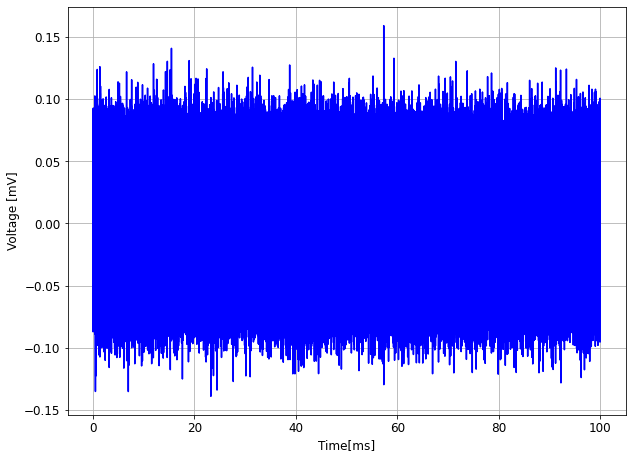

In [42]:
# Begin with the input-referred thermal noise density of your circuit
# In this example, the noise is from a 10k resistor
k = 1.38e-23
T = 300
en_2_10k = 4*k*T*10e3

# The noise bandwidth is the Nyquist rate of the sampled noise
# Here we assume a sample rate of 10MHz to capture a sufficient
# portion of the circuit's noise bandwidth
fenb = 5e6

# The input-referred rms noise is determined by the noise
# density and sample rate
vn_rms = np.sqrt(en_2_10k*fenb)

# Number of noise samples
N = 100e-3*fenb*2
t = np.arange(N) / fenb / 2

# Generate a random sequence with a Gaussian distribution
vn_in = np.random.normal(0, vn_rms, size=t.shape)

plot_xy(1e3*t, 1e3*vn_in, 'Time[ms]', 'Voltage [mV]')

1.6579850917704386e-16

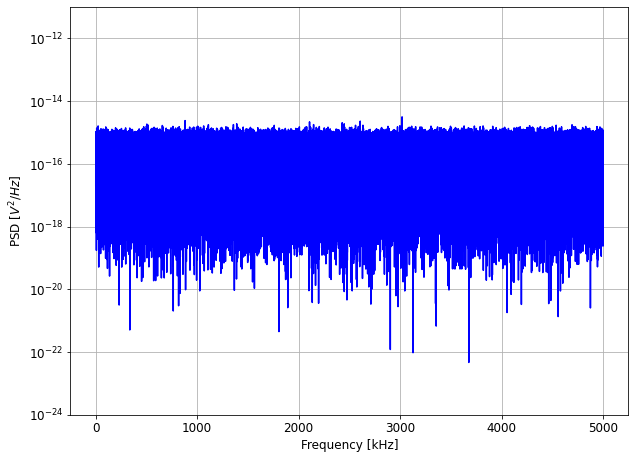

In [47]:
f, en_in_psd = signal.periodogram(vn_in, fenb*2)
plot_xlogy(1e-3*f[1:-2], en_in_psd[1:-2], 'Frequency [kHz]', r'PSD [$V^2/Hz$]', 1e-24, 1e-11)
np.mean(en_in_psd)

The integrated noise should total the specified $rms$ noise.

In [48]:
vn_rms_calc = np.sqrt(np.sum(en_in_psd)*10)
print('The rms noise calculated from the PSD is', 1e3*vn_rms_calc, 'mV')
print('The rms noise calculated from the time domain is', 1e3*np.std(vn_in), 'mV')

The rms noise calculated from the PSD is 0.02879225944364754 mV
The rms noise calculated from the time domain is 0.028792259443647536 mV


The generated noise sequence should be exported to use with an PWL source in SPICE:

In [49]:
with open('input_noise.csv', 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(zip(t,vn_in))

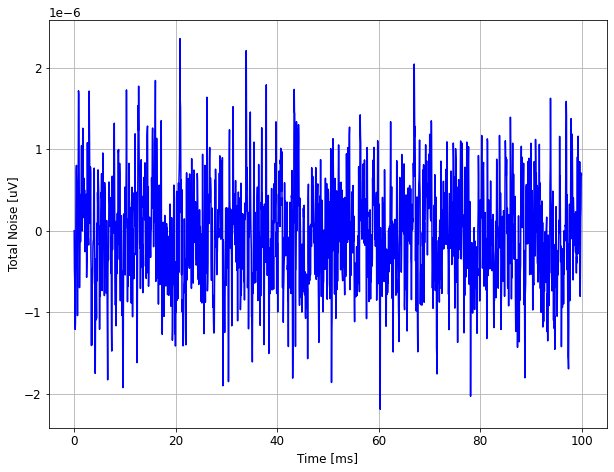

In [50]:
samplerate, data = wavfile.read('sampled_noise.wav')
time = np.arange(0,100e-3,1/samplerate)
if np.size(time) > np.size(data):
    time = time[0:np.size(data)]

# measured noise voltage
vn_meas = data[0:np.size(time)]*2/2**32

plot_xy(1e3*time, vn_meas, 'Time [ms]', 'Total Noise [uV]')

In [51]:
np.std(vn_meas)

6.351752654571424e-07

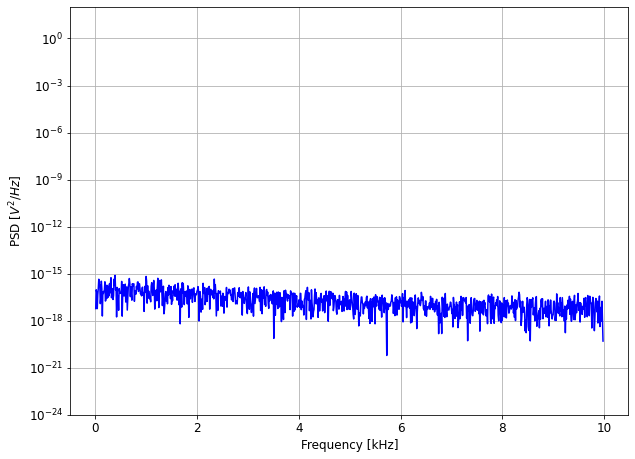

In [52]:
f, en_psd = signal.periodogram(vn_meas, samplerate)
plot_xlogy(1e-3*f[1:-2], en_psd[1:-2], 'Frequency [kHz]', r'PSD [$V^2/Hz$]', 1e-24, 1e2)

The $rms$ noise values calcualted from the time- and frequency-domain data should agree.

In [53]:
vn_rms_psd = np.sqrt(np.sum(en_psd)*10)
vn_rms_td = np.std(vn_meas)

print('The rms noise calculated from the PSD is', 1e6*vn_rms_psd, 'uV')
print('The rms noise calculated from the time domain is', 1e6*vn_rms_td, 'uV')

The rms noise calculated from the PSD is 0.6351752654571424 uV
The rms noise calculated from the time domain is 0.6351752654571424 uV
